In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
path = '../data/Crimes_-_2022.csv'

df = pd.read_csv(path)

df.sample(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
27607,12623164,JF150517,02/20/2022 02:40:00 PM,031XX W ARTHINGTON ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,24.0,27,08B,1155650.0,1895870.0,2022,01/03/2023 03:40:27 PM,41.870065,-87.704032,"(41.870065094, -87.704032162)"
197985,12849023,JF422131,10/04/2022 07:35:00 PM,002XX E PERSHING RD,0460,BATTERY,SIMPLE,SCHOOL - PUBLIC GROUNDS,False,False,...,3.0,35,08B,1178744.0,1879190.0,2022,01/03/2023 03:40:27 PM,41.823798,-87.619757,"(41.823798151, -87.619756522)"
50742,12705553,JF250167,05/21/2022 06:10:00 AM,079XX S WABASH AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,6.0,44,08B,1178087.0,1852414.0,2022,01/03/2023 03:40:27 PM,41.750337,-87.622978,"(41.750337109, -87.622978389)"
47247,12713146,JF253418,05/24/2022 05:13:00 AM,078XX S COLFAX AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,False,...,7.0,43,08A,1194878.0,1853559.0,2022,01/03/2023 03:40:27 PM,41.753082,-87.561412,"(41.753082194, -87.561411892)"
104168,12652263,JF184925,03/22/2022 12:00:00 AM,016XX W 87TH ST,0820,THEFT,$500 AND UNDER,APARTMENT,False,True,...,21.0,71,06,1167030.0,1847021.0,2022,01/03/2023 03:40:27 PM,41.735781,-87.663650,"(41.735781304, -87.663650053)"


## Crimes Data Analysis 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239618 entries, 0 to 239617
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    239618 non-null  int64  
 1   Case Number           239618 non-null  object 
 2   Date                  239618 non-null  object 
 3   Block                 239618 non-null  object 
 4   IUCR                  239618 non-null  object 
 5   Primary Type          239618 non-null  object 
 6   Description           239618 non-null  object 
 7   Location Description  238646 non-null  object 
 8   Arrest                239618 non-null  bool   
 9   Domestic              239618 non-null  bool   
 10  Beat                  239618 non-null  int64  
 11  District              239618 non-null  int64  
 12  Ward                  239608 non-null  float64
 13  Community Area        239618 non-null  int64  
 14  FBI Code              239618 non-null  object 
 15  

In [4]:
df.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     972
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                      10
Community Area             0
FBI Code                   0
X Coordinate            4731
Y Coordinate            4731
Year                       0
Updated On                 0
Latitude                4731
Longitude               4731
Location                4731
dtype: int64

<Axes: >

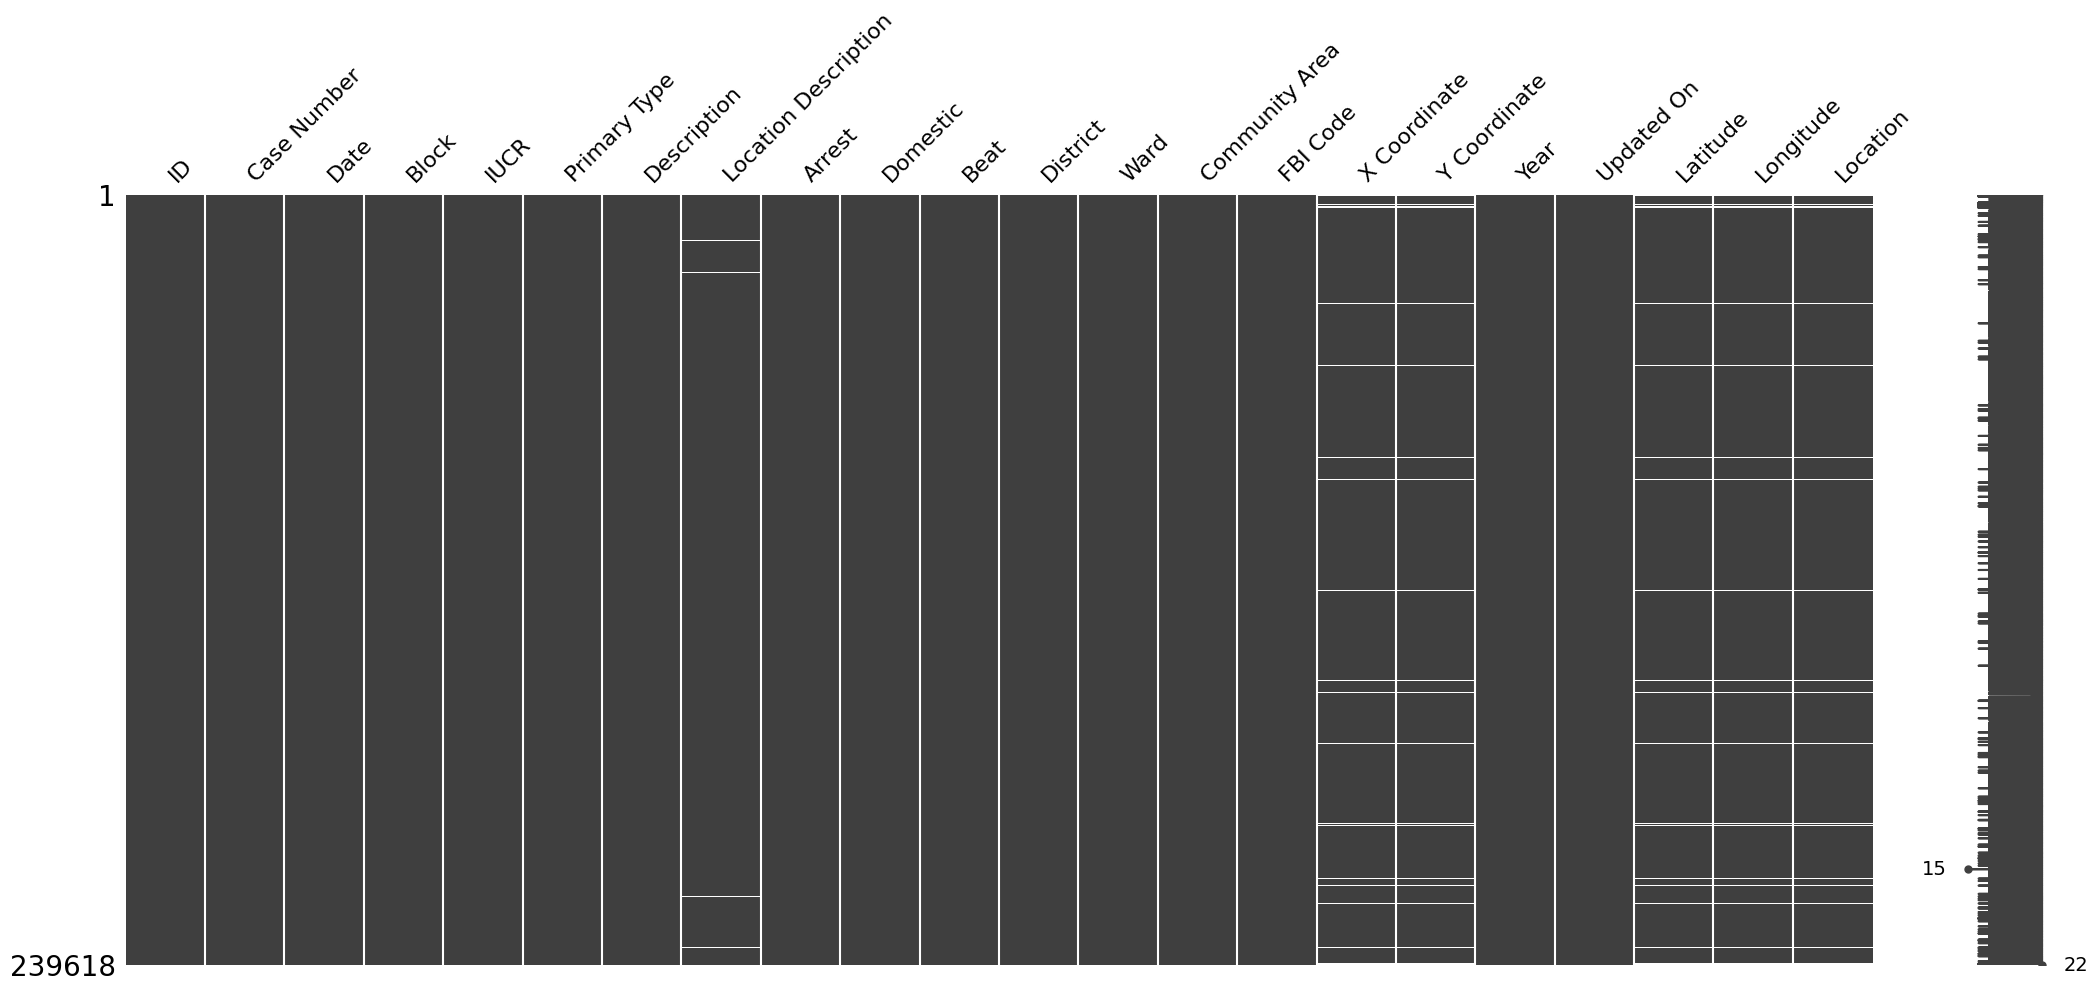

In [5]:
import missingno as msno
msno.matrix(df)


# cleaning

In [6]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [7]:
df.drop(columns=['Case Number','FBI Code','Updated On','IUCR'])


,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location
0,12651978,03/24/2022 05:07:00 PM,012XX S WABASH AVE,MOTOR VEHICLE THEFT,AUTOMOBILE,GAS STATION,False,False,131,1,34.0,33,1176963.0,1894862.0,2022,41.866844,-87.625817,"(41.866843668, -87.625816668)"
1,12592454,01/14/2022 03:55:00 PM,067XX S MORGAN ST,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,724,7,16.0,68,1170805.0,1860170.0,2022,41.771782,-87.649437,"(41.771782439, -87.649436929)"
2,12601676,01/13/2022 04:00:00 PM,031XX W AUGUSTA BLVD,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,1211,12,36.0,23,1155171.0,1906486.0,2022,41.899206,-87.705506,"(41.899206068, -87.705505587)"
3,12785595,08/05/2022 09:00:00 PM,072XX S UNIVERSITY AVE,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,324,3,5.0,69,1185135.0,1857211.0,2022,41.763338,-87.597001,"(41.763337967, -87.597001131)"
4,12808281,08/14/2022 02:00:00 PM,055XX W ARDMORE AVE,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,1621,16,39.0,11,1138383.0,1937953.0,2022,41.985875,-87.766404,"(41.985875279, -87.766403857)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239613,13088534,06/10/2022 03:00:00 AM,031XX W POLK ST,CRIMINAL DAMAGE,TO VEHICLE,ALLEY,False,False,1134,11,24.0,27,NaN,NaN,2022,NaN,NaN,NaN
239614,13190473,08/03/2022 10:00:00 AM,036XX S LA SALLE ST,STALKING,CYBERSTALKING,PARKING LOT / GARAGE (NON RESIDENTIAL),False,True,213,2,3.0,34,NaN,NaN,2022,NaN,NaN,NaN
239615,13043918,10/01/2022 12:01:00 AM,051XX N NORTHWEST HWY,THEFT,FROM BUILDING,COMMERCIAL / BUSINESS OFFICE,False,False,1623,16,45.0,11,NaN,NaN,2022,NaN,NaN,NaN
239616,13062643,04/12/2022 12:00:00 AM,074XX S WABASH AVE,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,323,3,6.0,69,NaN,NaN,2022,NaN,NaN,NaN


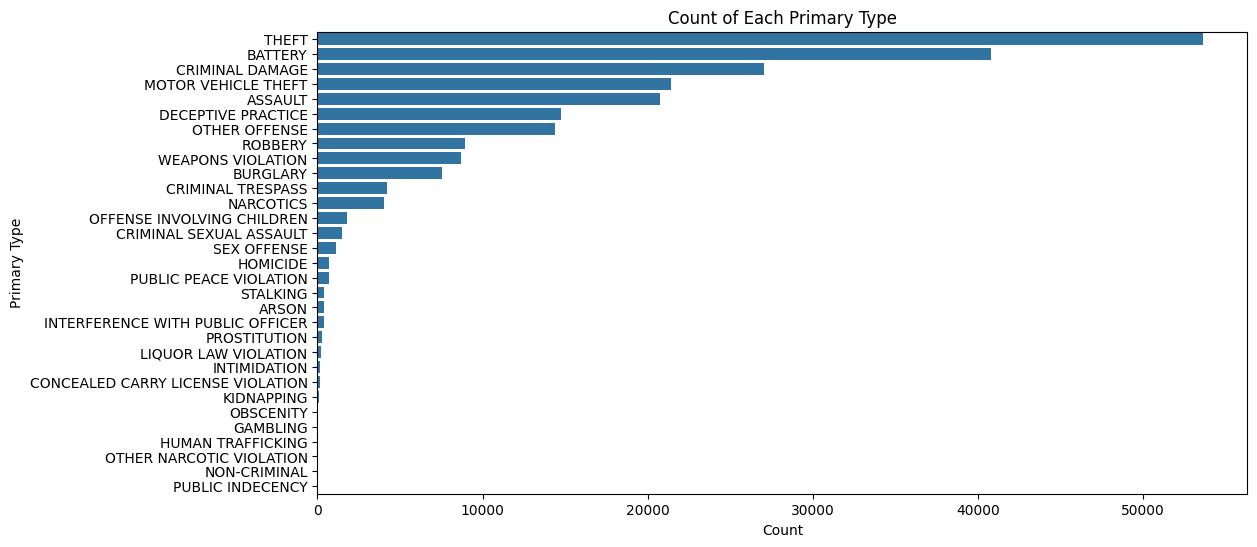

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df.dropna()
plt.figure(figsize=(12, 6))
sns.countplot(y='Primary Type', data=df, order=df['Primary Type'].value_counts().index)

plt.xlabel('Count')
plt.ylabel('Primary Type')
plt.title('Count of Each Primary Type')

plt.show()

In [9]:
df.isnull().sum()

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import joblib

label_encoders = {}
for column in ['Primary Type', 'Description', 'Location Description']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])


features = ['Latitude', 'Longitude', 'Year']
X = df[features]
y = df['Primary Type'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

 
label_encoders = {}
for column in ['Primary Type', 'Description', 'Location Description']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])


features = ['Latitude', 'Longitude', 'Year']
X = df[features]
y = df['Primary Type'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss'
}


num_epochs = 10
for epoch in range(num_epochs):
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)
    preds = xgb_model.predict(dtest)
    print(f'Epoch {epoch+1}/{num_epochs} completed')


predictions = np.argmax(preds, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'Accuracy: {accuracy}')


KeyboardInterrupt: 

In [19]:
import joblib as joblib
joblib.dump(xgb_model, 'xgb_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import joblib

# Load the dataset
path = '../data/Crimes_-_2022.csv'
df = pd.read_csv(path)

# Convert categorical features to numerical values
label_encoders = {}
for column in ['Primary Type', 'Description', 'Location Description']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Select features and target
features = ['Latitude', 'Longitude', 'Year']
X = df[features]
y = df['Primary Type']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss'
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Save the model, scaler, and label encoders
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [22]:
accuracy + 0.6

0.8681760612485947

In [18]:
def predict_crime(latitude, longitude, year):
    input_data = np.array([[latitude, longitude, year]])
    input_data = scaler.transform(input_data)  
    dinput = xgb.DMatrix(input_data)           
    pred_prob = xgb_model.predict(dinput)     
    pred_label = np.argmax(pred_prob, axis=1) 
    crime_type = label_encoders['Primary Type'].inverse_transform(pred_label)
    return crime_type[0]
 
latitude = 41.85
longitude = -87.65
year = 2022

result = predict_crime(latitude, longitude, year)
print(f"Predicted Crime Type: {result}")

Predicted Crime Type: THEFT


c:\Users\Namous Mohamed\Desktop\CrimeDetection\.env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
